In [1]:
import os
import shutil
#BEFORE YOU RUN THIS FILE, YOU SHOULD RUN THE CLEANING ARCHETECTURE FIRST FOR THE FILE AUDIOS, CHECK THE OTHER FILE.
#SET UP for MossFormer
if os.path.exists('checkpoints'):
    shutil.rmtree('checkpoints')

!pip install clearvoice
import torch
from clearvoice import ClearVoice
import numpy as np
import librosa
import soundfile as sf
from IPython.display import Audio, display

# 2. Initialize Engine (This will now re-download correctly)
print("Initializing MossFormer2 Engine (Best of Both Worlds)...")
mv_engine = ClearVoice(task='speech_separation', model_names=['MossFormer2_SS_16K'])
#After this runs you will need to restart collab session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.3/183.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.1 MB/s eta 0:00:00
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=1df0b956badec69ddcb93e9b03cf0057be4b615a4076a2faf24cb4e4db660541
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2


KeyboardInterrupt: 

In [41]:
import os
import os
import torch
import torchaudio
import numpy as np
import scipy.signal as signal
import gc
from google.colab import drive

# 1. Mount Drive

drive.mount('/content/drive')

# 2. Path Setup (Change File name here)
session_path = "/content/drive/My Drive/GEEKED/Audio_Files/Session_008"

doc_path = os.path.join(session_path, "doc_clean.wav")
pat_path = os.path.join(session_path, "pat_clean.wav")
import librosa
import numpy as np

# 1. Load both wav files into numpy arrays, .wavs should be in 16k
doctor_audio, sr1 = librosa.load(doc_path, sr=16000)
patient_audio, sr2 = librosa.load(pat_path, sr=16000)

# 2. Ensure they are the exact same length to avoid math errors
min_length = min(len(doctor_audio), len(patient_audio))
doctor_audio = doctor_audio[:min_length]
patient_audio = patient_audio[:min_length]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import numpy as np
import scipy.signal as signal
#Does the gcc phase transform calculations, essentially shows us information about phase differences
def calculate_gcc_phat(mic1_chunk, mic2_chunk, sample_rate=16000, max_tau=30, interp=16):
    window = np.hanning(len(mic1_chunk))
    c1, c2 = mic1_chunk * window, mic2_chunk * window
    n = len(mic1_chunk) + len(mic2_chunk)
    STFT1, STFT2 = np.fft.rfft(c1, n=n), np.fft.rfft(c2, n=n)
    freqs = np.fft.rfftfreq(n, d=1.0/sample_rate)
    voice_band = (freqs > 300) & (freqs < 3400)
    R = STFT1 * np.conj(STFT2)
    phat_weighting = np.zeros_like(R)
    phat_weighting[voice_band] = R[voice_band] / (np.abs(R[voice_band]) + 1e-10)
    cc = np.fft.irfft(phat_weighting, n=(interp * n))
    center = int(interp * n / 2)
    cc = np.concatenate((cc[-center:], cc[:center+1]))
    bound = int(interp * max_tau)
    cc = cc[center - bound : center + bound + 1]
    peak_index = np.argmax(np.abs(cc))
    tau = (peak_index - bound) / float(interp)
    return tau, np.abs(cc[peak_index]) / (np.mean(np.abs(cc)) + 1e-10)

🕵️ Mapping raw spatial dots for 9333 windows...


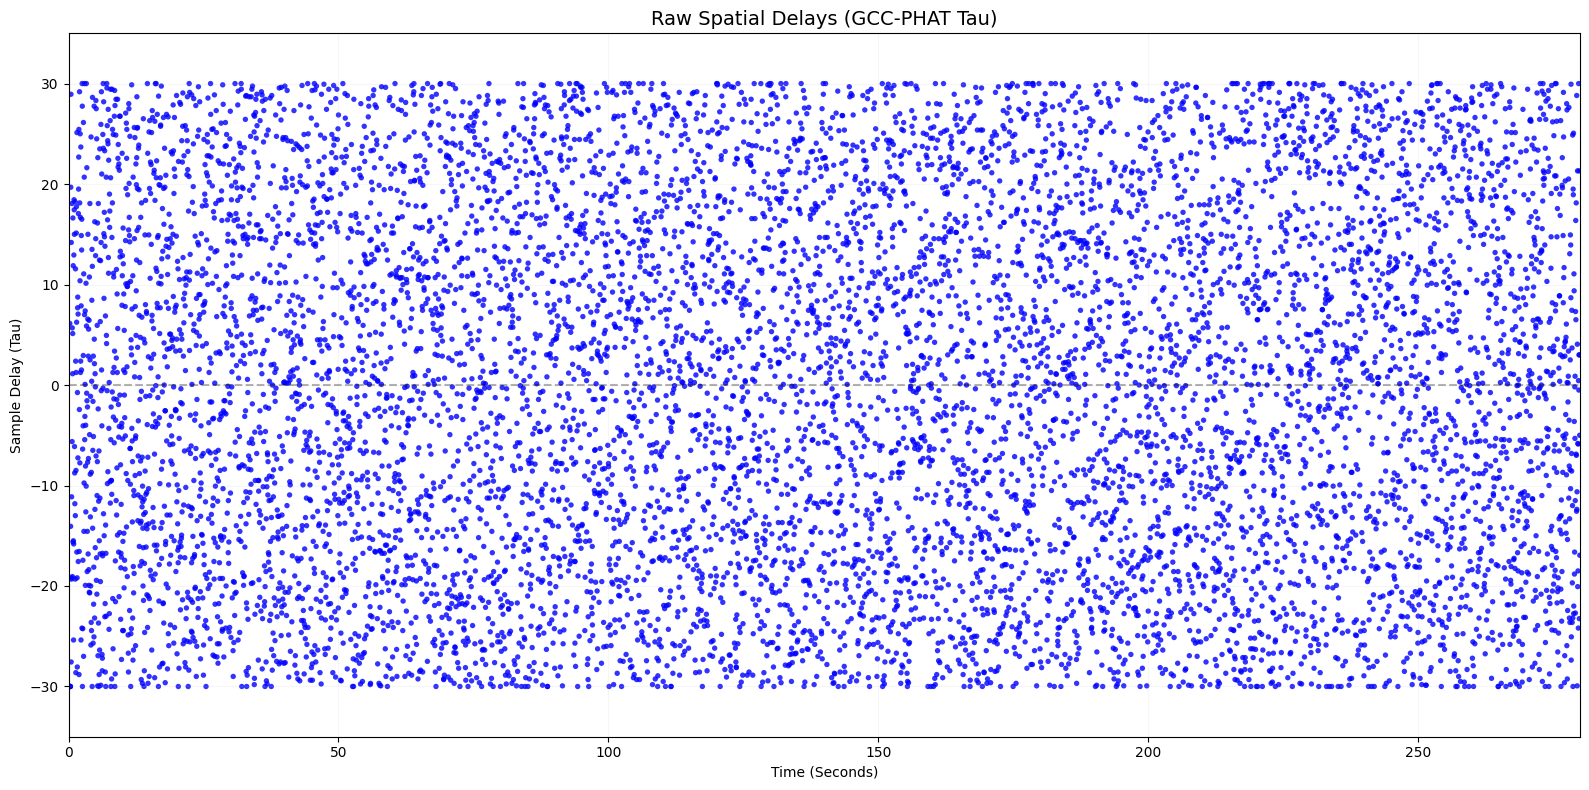

In [43]:
import matplotlib.pyplot as plt
import numpy as np
#Plots gcc phat info
def plot_raw_spatial_delays(doc_audio, pat_audio, start_sec=0, end_sec=280, sr=16000, window_ms=30):
    window_samples = int((window_ms / 1000) * sr)
    num_windows = int((end_sec - start_sec) * sr // window_samples)

    times, taus = [], []

    print(f"🕵️ Mapping raw spatial dots for {num_windows} windows...")

    for i in range(num_windows):
        s = int(start_sec * sr) + (i * window_samples)
        e = s + window_samples
        if e > len(doc_audio): break

        c1, c2 = doc_audio[s:e], pat_audio[s:e]

        # Max-normalize the chunk to help the radar see quiet voices
        m = max(np.max(np.abs(c1)), np.max(np.abs(c2)))

        if m > 1e-5:
            # GCC-PHAT function to get the raw Tau
            tau, _ = calculate_gcc_phat(c1/m, c2/m, max_tau=30, interp=16)

            times.append(start_sec + (i * window_ms / 1000))
            taus.append(tau)

    # --- SINGLE PLOT: RAW SPATIAL DELAYS ---
    plt.figure(figsize=(16, 8))

    # We keep the exact styling from Plot 2: Blue dots, small size, subtle alpha
    plt.scatter(times, taus, c='blue', s=15, alpha=0.8, edgecolors='none')

    # Keeping the horizontal center line for reference
    plt.axhline(0, color='black', linestyle='--', alpha=0.3, label='Center')

    plt.title("Raw Spatial Delays (GCC-PHAT Tau)", fontsize=14)
    plt.ylabel("Sample Delay (Tau)")
    plt.xlabel("Time (Seconds)")
    plt.ylim(-35, 35) # Matching your previous range

    plt.xlim(start_sec, end_sec)
    plt.grid(True, alpha=0.1) # Light grid for better readability
    plt.tight_layout()
    plt.show()

# Run it
plot_raw_spatial_delays(doctor_audio, patient_audio)

Gathering raw spatial data...
Filtering out the noise...


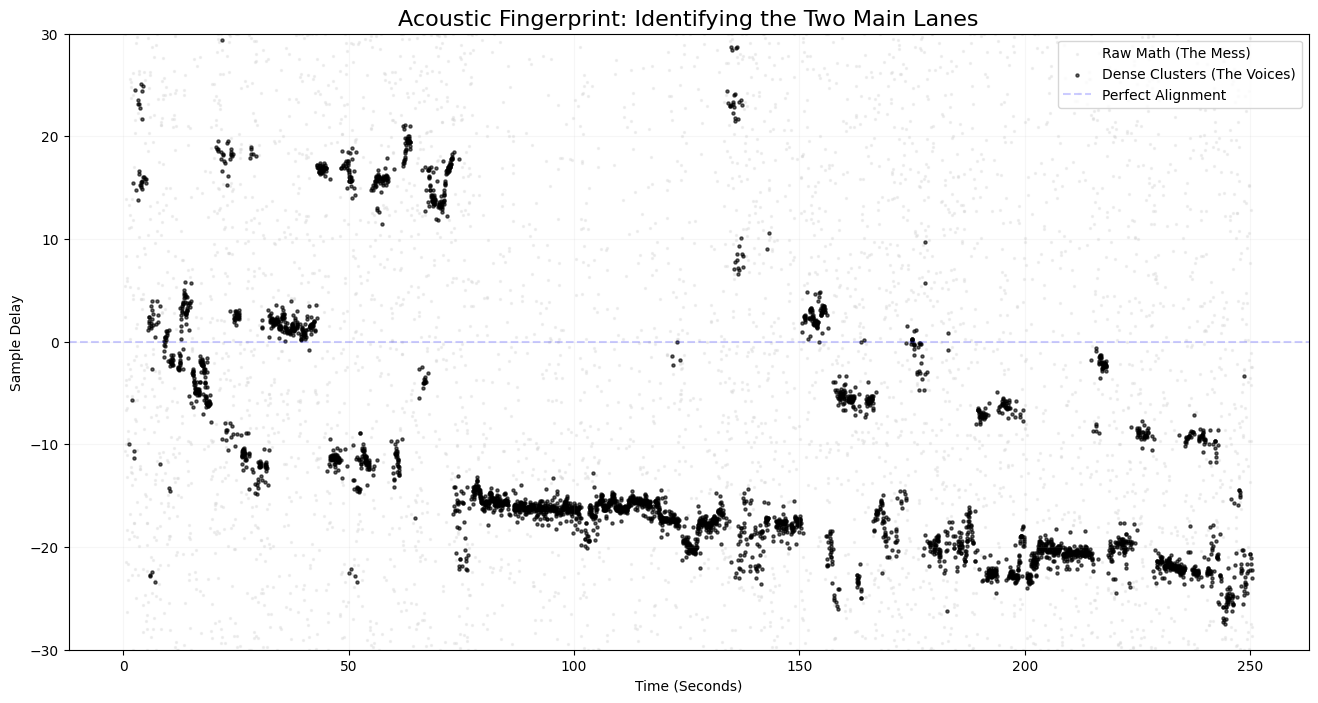

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
#trims the graph to find the denser clusters and get rid of noise
def find_dense_clusters(doc_audio, pat_audio, sr=16000, window_ms=30):
    window_samples = int((window_ms / 1000) * sr)
    num_windows = len(doc_audio) // window_samples

    raw_points = []
    print("Gathering raw spatial data...")

    # 1. Collect all points where there is clear audio
    for i in range(num_windows):
        s, e = i * window_samples, (i+1) * window_samples
        if np.max(np.abs(doc_audio[s:e])) > 0.0006:
            tau, _ = calculate_gcc_phat(doc_audio[s:e], pat_audio[s:e], max_tau=30)
            raw_points.append([i * (window_ms/1000), tau])

    points = np.array(raw_points)

    # 2. Density Filtering (The "Loner" Filter)
    # We look at every dot and ask: "Are there at least 5 dots within a small radius?"
    # This kills the 'jumps' and the noise instantly.
    print("Filtering out the noise...")
    tree = KDTree(points)
    # Radius of 2 seconds and 2 samples of delay
    count = tree.query_radius(points, r=2.0, count_only=True)

    # Keep only points in dense 'lanes'
    dense_points = points[count > 10]

    return points, dense_points

# --- RUN THE CLUSTER FINDER ---
raw_all, raw_dense = find_dense_clusters(doctor_audio, patient_audio)
def visualize_clusters(all_points, dense_points):
    plt.figure(figsize=(16, 8))

    # Plot the raw "Mess" in light grey
    plt.scatter(all_points[:, 0], all_points[:, 1], color='lightgrey', s=2, alpha=0.3, label="Raw Math (The Mess)")

    # Plot the "Dense Clusters" (The real voices) in Black
    plt.scatter(dense_points[:, 0], dense_points[:, 1], color='black', s=5, alpha=0.6, label="Dense Clusters (The Voices)")

    plt.axhline(0, color='blue', linestyle='--', alpha=0.2, label="Perfect Alignment")
    plt.title("Acoustic Fingerprint: Identifying the Two Main Lanes", fontsize=16)
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Sample Delay")
    plt.ylim(-30, 30)
    plt.legend()
    plt.grid(True, alpha=0.1)
    plt.show()

visualize_clusters(raw_all, raw_dense)

In [6]:
import numpy as np
#my human-based RL function (I was the agent and policy)
def run_ultimate_robust_radar(dense_points):
    pts = dense_points[dense_points[:, 0].argsort()]
    lanes = []
    locked = False
    labeled_data = []

    # --- TUNING PARAMETERS ---
    momentum = 0.96        # Base momentum
    max_step = 1.2         # Drift speed
    shield_limit = 23.0    # THE FIX: No dot allowed > 23 samples from a lane
    doubt_width = 4.0      # The "Iffy" middle zone

    last_t = 0
    upper_idx = None # Geometric lock (Upper vs Lower)

    print("Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...")

    for i, (t, tau) in enumerate(pts):
        dt = t - last_t

        # 1. LOCAL DENSITY VETTING (Filter outliers)
        start_idx = max(0, i-15); end_idx = min(len(pts), i+15)
        neighbors = pts[start_idx:end_idx]
        friend_count = sum(1 for nt, ntau in neighbors if abs(ntau - tau) < 3.0 and abs(nt - t) < 1.0)

        if friend_count < 4:
            labeled_data.append([t, tau, lanes[0] if len(lanes)>0 else tau,
                                 lanes[1] if len(lanes)>1 else None, "Noise"])
            continue

        # 2. DISCOVERY
        if len(lanes) == 0:
            lanes.append(tau)
            labeled_data.append([t, tau, tau, None, "L1"])
            continue

        # 3. DUAL-LANE TRACKING (The "Shielded & Territorial" Mode)
        if locked:
            if upper_idx is None:
                upper_idx = 0 if lanes[0] > lanes[1] else 1
            lower_idx = 1 if upper_idx == 0 else 0

            # --- SHIELDING & SKEPTICISM ---
            # Reject if dot is physically impossible relative to current lanes
            is_outlier = (tau > lanes[upper_idx] + shield_limit) or (tau < lanes[lower_idx] - shield_limit)
            if is_outlier:
                labeled_data.append([t, tau, lanes[0], lanes[1], "Noise"])
                continue

            # Identify target lane based on territory (Midpoint Fence)
            midpoint = (lanes[0] + lanes[1]) / 2
            target, other = (0, 1) if abs(tau - lanes[0]) < abs(tau - lanes[1]) else (1, 0)

            # --- PROBABILISTIC DOUBT ZONE ---
            # If dot is in the middle, increase momentum (become stubborn)
            dist_to_mid = abs(tau - midpoint)
            active_momentum = 0.999 if dist_to_mid < doubt_width else momentum

            # --- SEARCH & SNAP (SESSION 9 FIX) ---
            # If we haven't seen dots in a while and this is a HIGH DENSITY cluster
            is_global_jump = (dt > 2.0 and friend_count > 12 and abs(tau - lanes[target]) > 8.0)

            # TERRITORIAL PROTECTION: No crossing the midpoint!
            is_illegal_cross = (target == upper_idx and tau < midpoint) or (target == lower_idx and tau > midpoint)

            if not is_illegal_cross:
                if is_global_jump:
                    # SNAP the rig to the new cluster location
                    shift = tau - lanes[target]
                    lanes[target] = tau
                    lanes[other] += (shift * 0.8) # Loose tether nudge
                else:
                    # NORMAL TRACKING
                    shift = np.clip((tau - lanes[target]) * (1 - active_momentum), -max_step, max_step)
                    lanes[target] += shift
                    lanes[other] += (shift * 0.5) # The "Smaller Nudge" logic

                last_t = t
                labeled_data.append([t, tau, lanes[0], lanes[1], "L1" if target == 0 else "L2"])
            else:
                labeled_data.append([t, tau, lanes[0], lanes[1], "Noise"])

        # 4. DISCOVERY MODE (FINDING B)
        else:
            if abs(tau - lanes[0]) < 5.0:
                lanes[0] = lanes[0] * momentum + tau * (1 - momentum)
                labeled_data.append([t, tau, lanes[0], None, "L1"])
            elif 12.0 < abs(tau - lanes[0]) < 30.0:
                # Validation cluster
                if friend_count > 10:
                    lanes.append(tau)
                    locked = True
                    labeled_data.append([t, tau, lanes[0], lanes[1], "L2"])
                else:
                    labeled_data.append([t, tau, lanes[0], None, "Finding"])

    # --- FINAL IDENTITY MAPPING ---
    res = np.array(labeled_data, dtype=object)
    l1_m = np.mean(res[:, 2].astype(float))
    l2_vals = [x for x in res[:, 3] if x is not None]
    l2_m = np.mean(l2_vals) if l2_vals else 100
    mapping = {"L1": "Doctor", "L2": "Patient"} if abs(l1_m) < abs(l2_m) else {"L1": "Patient", "L2": "Doctor"}
    for row in res:
        row[4] = mapping.get(row[4], row[4])
    return res

Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...


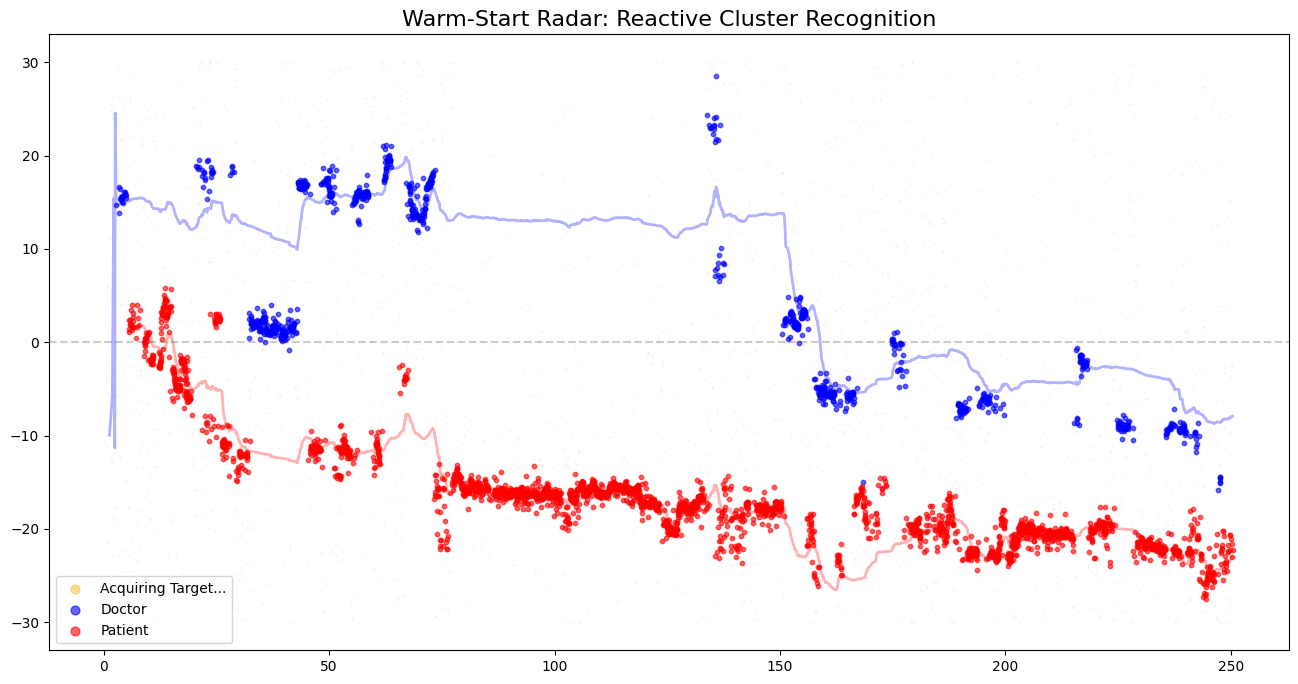

In [32]:
# see the radar algo at work
def visualize_warm_start(res, all_raw):
    plt.figure(figsize=(16, 8))
    plt.scatter(all_raw[:, 0], all_raw[:, 1], color='lightgrey', s=1, alpha=0.1)

    t = res[:, 0].astype(float)
    tau = res[:, 1].astype(float)
    l1 = res[:, 2].astype(float)
    l2 = np.array([float(x) if x is not None else np.nan for x in res[:, 3]])
    labels = res[:, 4]

    # Plot Finding Phase (Yellow/Orange)
    find_mask = (labels == "Finding_Patient") | (labels == "Finding_Doctor")
    plt.scatter(t[find_mask], tau[find_mask], color='orange', s=10, alpha=0.4, label="Acquiring Target...")

    # Plot Confirmed Speakers
    plt.scatter(t[labels == "Doctor"], tau[labels == "Doctor"], color='blue', s=10, alpha=0.6, label="Doctor")
    plt.scatter(t[labels == "Patient"], tau[labels == "Patient"], color='red', s=10, alpha=0.6, label="Patient")

    # Lines
    plt.plot(t, l1, color='blue', linewidth=2, alpha=0.3)
    plt.plot(t, l2, color='red', linewidth=2, alpha=0.3)

    plt.axhline(0, color='black', linestyle='--', alpha=0.2)
    plt.title("Warm-Start Radar: Reactive Cluster Recognition", fontsize=16)
    plt.legend(markerscale=2)
    plt.show()

# --- RUN IT ---
warm_results = run_ultimate_robust_radar(raw_dense)
visualize_warm_start(warm_results, raw_all)

In [8]:
import torch
from clearvoice import ClearVoice
import os
#Run Moss to get AI outputs
# Initialize the Engine
mv_engine = ClearVoice(task='speech_separation', model_names=['MossFormer2_SS_16K'])

# Path to the file containing both voices
input_path = os.path.join(session_path, "doc_clean.wav")

print(f"🚀 AI is unweaving voices from: {os.path.basename(input_path)}")

# RUN THE ENGINE
with torch.no_grad():
    m1_sep = mv_engine(input_path=input_path, online_write=False)

# Track 0 and Track 1 are now sitting directly in your RAM
print("✅ AI Separation Complete.")

downloading checkpoint for MossFormer2_SS_16K


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

🚀 AI is unweaving voices from: doc_clean.wav
Running MossFormer2_SS_16K ...


100%|██████████| 1/1 [01:09<00:00, 69.76s/it]

✅ AI Separation Complete.


In [9]:
import numpy as np

def calculate_rms(audio_chunk):
    return np.sqrt(np.mean(np.square(audio_chunk)) + 1e-10)

# This is my rudimentary identification of who is doctor and who is patient based on loudness in segments
# If I had more time, I would run WHISPR on every output and see who says "You" more and sciency language more like "Sugar" "Blood" etcetc to see who is doctor
def classify_lanes_by_energy(radar_results, doc_audio, sr=16000):
    """
    Identifies which radar lane belongs to the Doctor by matching
    spatial hits to the loudest parts of the doc_clean mic.
    """
    hop = int(0.04 * sr)
    rms_doc = np.array([np.sqrt(np.mean(doc_audio[i:i+hop]**2))
                        for i in range(0, len(doc_audio)-hop, hop)])
    # Focus on the top 30% loudest segments to find the primary speaker
    threshold = np.percentile(rms_doc, 70)
    loud_times = np.where(rms_doc > threshold)[0] * 0.04

    l1_hits, l2_hits = 0, 0
    for t_loud in loud_times:
        idx = np.abs(radar_results[:, 0].astype(float) - t_loud).argmin()
        tau = float(radar_results[idx, 1])
        l1, l2 = float(radar_results[idx, 2]), float(radar_results[idx, 3])

        if abs(tau - l1) < 4.0: l1_hits += 1
        if l2 is not None and abs(tau - l2) < 4.0: l2_hits += 1

    mapping = {"L1": "Doctor", "L2": "Patient"} if l1_hits >= l2_hits else {"L1": "Patient", "L2": "Doctor"}
    print(f"📊 Identity Match: L1({l1_hits} hits), L2({l2_hits} hits). Mapping: {mapping}")
    return mapping

def event_based_stitcher_with_forensics(radar_truth, clusters_t0, clusters_t1, track_a, track_b, sr=16000, window_sec=0.04):
    """
    v3 Stitcher: Sticky identity, 10ms cross-fades, and gap bridging to stop popping.
    """
    total_samples = len(track_a)
    window_samples = int(window_sec * sr)
    fade_samples = int(0.010 * sr)

    final_doctor = np.zeros_like(track_a)
    final_patient = np.zeros_like(track_a)

    CORE_RADIUS = 5.0
    STICKY_RADIUS = 12.0
    GAP_BRIDGE_LIMIT = 4 # Bridge up to 160ms of silence

    radar_times = radar_truth[:, 0].astype(float)
    l1_vals = radar_truth[:, 2].astype(float)
    l2_vals = np.array([float(x) if x is not None else np.nan for x in radar_truth[:, 3]])

    decision_log = []
    prev_id_a, prev_id_b = None, None
    gap_a, gap_b = 0, 0

    def get_radar_lanes(t):
        idx = np.abs(radar_times - t).argmin()
        return l1_vals[idx], l2_vals[idx]

    def identify_with_hysteresis(taus, d_lane, p_lane, last_id, gap_count):
        if not taus:
            if last_id is not None and gap_count < GAP_BRIDGE_LIMIT:
                return last_id, gap_count + 1
            return None, 0
        loc = np.median(taus)
        r_doc = STICKY_RADIUS if last_id == "Doctor" else CORE_RADIUS
        r_pat = STICKY_RADIUS if last_id == "Patient" else CORE_RADIUS
        if abs(loc - d_lane) < r_doc: return "Doctor", 0
        if not np.isnan(p_lane) and abs(loc - p_lane) < r_pat: return "Patient", 0
        return None, 0

    fade_in = np.linspace(0, 1, fade_samples)
    fade_out = np.linspace(1, 0, fade_samples)

    for i in range(0, total_samples - window_samples, window_samples):
        s, e = i, i + window_samples
        t_now = (s + e) / (2 * sr)
        d_lane, p_lane = get_radar_lanes(t_now)

        ca, cb = track_a[s:e].copy(), track_b[s:e].copy()
        t0_taus = [pt[1] for pt in clusters_t0 if s/sr <= pt[0] < e/sr]
        t1_taus = [pt[1] for pt in clusters_t1 if s/sr <= pt[0] < e/sr]

        id_a, gap_a = identify_with_hysteresis(t0_taus, d_lane, p_lane, prev_id_a, gap_a)
        id_b, gap_b = identify_with_hysteresis(t1_taus, d_lane, p_lane, prev_id_b, gap_b)

        # Logging for the plot
        if t0_taus: decision_log.append([t_now, np.median(t0_taus), "TrackA", id_a])
        if t1_taus: decision_log.append([t_now, np.median(t1_taus), "TrackB", id_b])

        # Apply Fades to prevent popping
        if id_a is not None and prev_id_a is None: ca[:fade_samples] *= fade_in
        if id_b is not None and prev_id_b is None: cb[:fade_samples] *= fade_in

        if id_a == "Doctor": final_doctor[s:e] = ca
        elif id_a == "Patient": final_patient[s:e] = ca
        if id_b == "Doctor":
            if not np.any(final_doctor[s:e]): final_doctor[s:e] = cb
        elif id_b == "Patient":
            if not np.any(final_patient[s:e]): final_patient[s:e] = cb
        prev_id_a, prev_id_b = id_a, id_b

    return final_doctor, final_patient, np.array(decision_log, dtype=object)

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def plot_live_decisions(start_sec, end_sec, warm_results, forensic_log):
    """
    Overlay plot showing raw AI clusters vs. Stitcher's final routing decisions.
    - Raw Clusters = Small Gray dots
    - Doctor Decisions = Bold Blue dots
    - Patient Decisions = Bold Red dots
    """
    # 1. Extract Raw Clusters (The "Warm Results" from Radar)
    # Expected format: [[time, tau, weight], ...]
    raw_data = np.array(warm_results)
    raw_times = raw_data[:, 0].astype(float)
    raw_taus = raw_data[:, 1].astype(float)

    # 2. Extract Stitcher Decisions (The "Forensic Log")
    # Expected format: [[time, median_tau, track_id, assigned_label], ...]
    log_data = np.array(forensic_log, dtype=object)
    log_times = log_data[:, 0].astype(float)
    log_taus = log_data[:, 1].astype(float)
    log_tracks = log_data[:, 2]
    log_labels = log_data[:, 3]

    plt.figure(figsize=(18, 9))

    # --- LAYER 1: THE RAW CLUSTERS (Background "Truth") ---
    # These represent EVERY spatial hit the AI found before the stitcher touched them.
    plt.scatter(raw_times, raw_taus, c='gray', s=5, alpha=0.15, label='Raw AI Clusters')

    # --- LAYER 2: THE STITCHER DECISIONS (Foreground "Routing") ---
    # Separate by Track A and Track B to see if MossFormer was "swapping"

    for track_name, marker in [("TrackA", "o"), ("TrackB", "x")]:
        mask = (log_tracks == track_name)
        t_subset = log_times[mask]
        tau_subset = log_taus[mask]
        label_subset = log_labels[mask]

        # Color-code based on final identity
        colors = ['#1f77b4' if L == 'Doctor' else '#d62728' if L == 'Patient' else 'none' for L in label_subset]

        # Only plot if there's an actual assignment (ignores the "none" cases)
        plt.scatter(t_subset, tau_subset, c=colors, s=35, marker=marker,
                    alpha=0.8, edgecolors='none', label=f'Decision: {track_name}')

    # --- STYLING & CONTEXT ---
    plt.axhline(0, color='black', linestyle='--', alpha=0.2)
    plt.ylim(-35, 35)
    plt.xlim(start_sec, end_sec)

    plt.title(f"Forensic Audit: AI Clusters vs. Stitcher Decisions ({start_sec}s - {end_sec}s)", fontsize=16)
    plt.ylabel("Sample Delay (Tau)")
    plt.xlabel("Time (Seconds)")

    # Custom Forensic Legend
    legend_elements = [
        Line2D([0], [0], marker='.', color='gray', label='Raw Clusters (AI Hits)', linestyle='None', markersize=10, alpha=0.4),
        Line2D([0], [0], marker='o', color='w', label='Track A (MossFormer)', markerfacecolor='black', markersize=8),
        Line2D([0], [0], marker='x', color='w', label='Track B (MossFormer)', markeredgecolor='black', markersize=8),
        Line2D([0], [0], color='#1f77b4', lw=4, label='Doctor (Final Assignment)'),
        Line2D([0], [0], color='#d62728', lw=4, label='Patient (Final Assignment)')
    ]
    plt.legend(handles=legend_elements, loc='upper right', frameon=True, shadow=True)

    plt.grid(True, alpha=0.1)
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# plot_live_decisions(0, 250, warm_results, forensic_log)

In [47]:

def harvest_ai_clusters(ai_track, other_mic):
        # We use the 'Ultra-Sensitive' cluster finder you liked
        _, dense_pts = find_dense_clusters(ai_track, other_mic, sr=16000)
        return dense_pts
track_a = m1_sep[0].squeeze()
track_b = m1_sep[1].squeeze()

# 2. HARVEST CLUSTERS FROM AI TRACKS
# We probe both tracks to find where the voices are sitting spatially
print("🔎 Probing AI Track A for clusters...")
clusters_t0 = harvest_ai_clusters(track_a, patient_audio) # Compares AI output to Raw Patient Mic

print("🔎 Probing AI Track B for clusters...")
clusters_t1 = harvest_ai_clusters(track_b, patient_audio)

# 3. RUN THE FORENSIC STITCHER
# This generates the audio AND the internal log of every decision made
finaldoc, finalpat, forensic_log = event_based_stitcher_with_forensics(
    warm_results,
    clusters_t0,
    clusters_t1,
    track_a,
    track_b
)

# 4. PLOT THE LIVE DECISIONS
plot_live_decisions(0, 250, warm_results, forensic_log)

# 5. LISTEN TO THE RESULTS
from IPython.display import Audio, display
print("🔊 Final Doctor Result:")
display(Audio(finaldoc, rate=16000))
print("🔊 Final Patient Result:")
display(Audio(finalpat, rate=16000))

Output hidden; open in https://colab.research.google.com to view.

In [39]:
# Assuming m1_sep and m2_sep are already generated from the previous code
print("--- RAW MOSSFORMER OUTPUTS (MIC 1) ---")
print("These are the AI's 'Best Guess' before the Radar sorts them.")
display(Audio(m1_sep[0].squeeze(), rate=16000))
display(Audio(m1_sep[1].squeeze(), rate=16000))

Output hidden; open in https://colab.research.google.com to view.

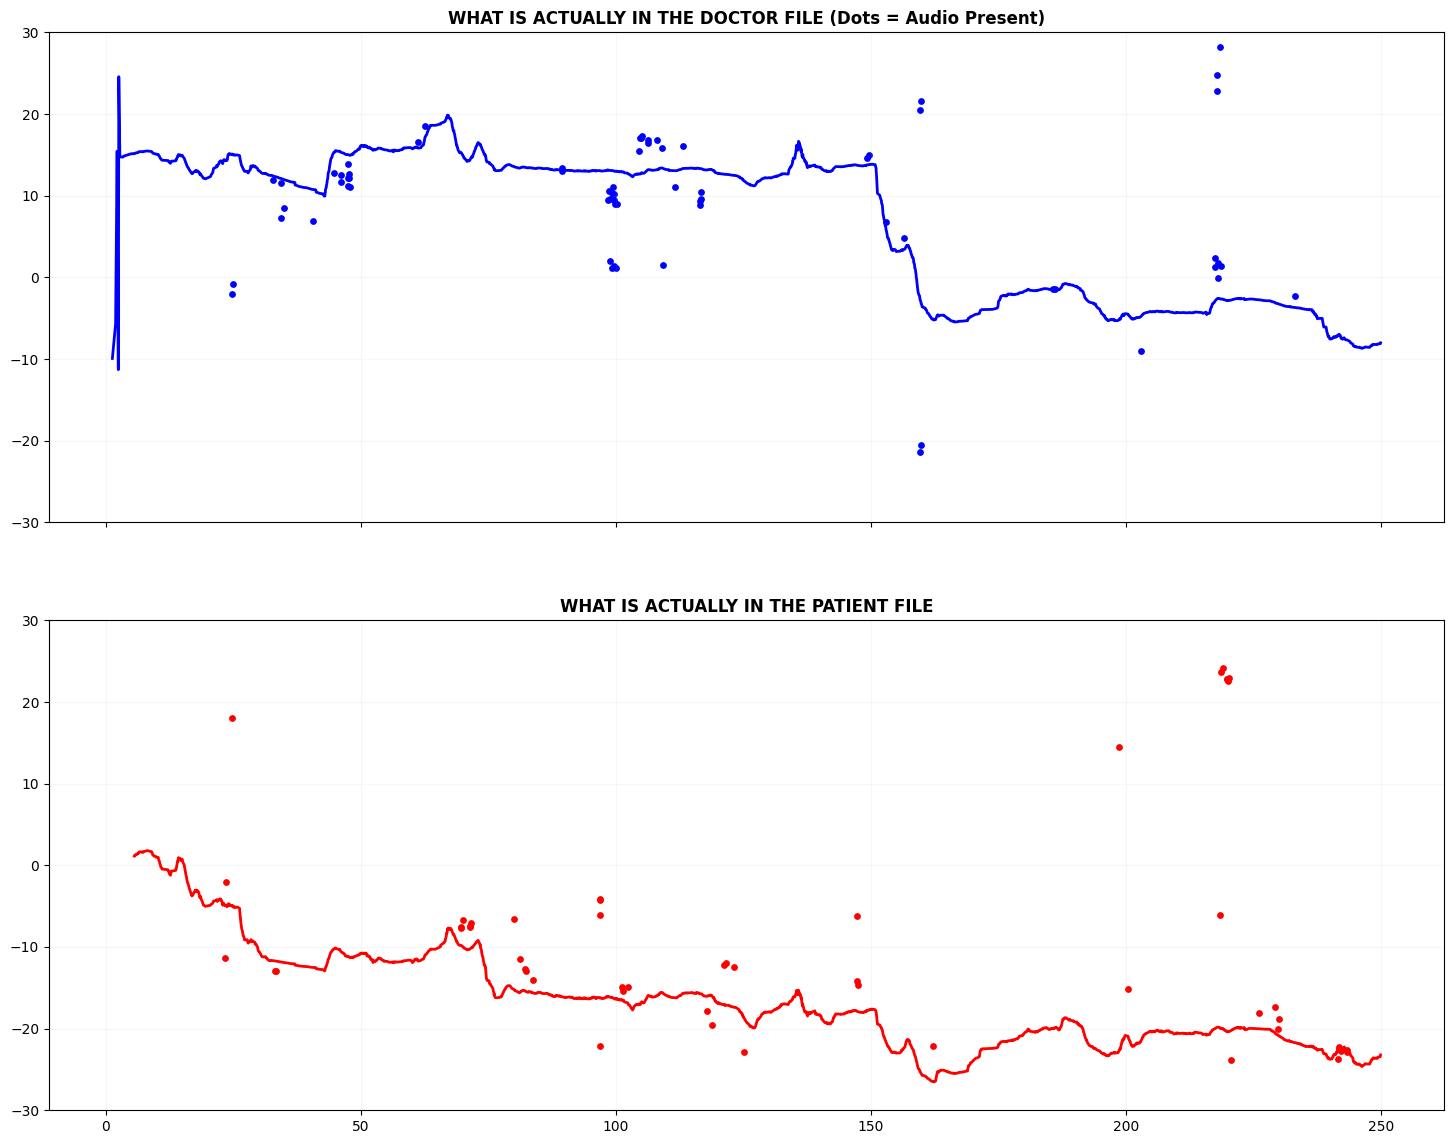

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def true_forensic_audit(start_s, end_s, radar_truth, clusters_t0, clusters_t1, f_doc, f_pat, sr=16000):
    """
    Shows which AI dots actually resulted in audio in the final files.
    """
    r_win = radar_truth[(radar_truth[:, 0].astype(float) >= start_s) & (radar_truth[:, 0].astype(float) <= end_s)]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14), sharex=True)

    # PANEL 1: DOCTOR FILE AUDIT
    # We only plot dots from Track A/B IF they actually exist in the final_doctor audio
    ax1.plot(r_win[:, 0].astype(float), r_win[:, 2].astype(float), color='blue', lw=2, label="Doctor Lane")

    for t, tau in clusters_t0:
        if start_s <= t <= end_s:
            # Check if there is actual audio in final_doctor at this time
            idx = int(t * sr)
            if idx < len(f_doc) and np.abs(f_doc[idx:idx+640]).max() > 0.005:
                ax1.scatter(t, tau, color='blue', s=15)

    ax1.set_title("WHAT IS ACTUALLY IN THE DOCTOR FILE (Dots = Audio Present)", fontweight='bold')
    ax1.set_ylim(-30, 30); ax1.grid(True, alpha=0.1)

    # PANEL 2: PATIENT FILE AUDIT
    ax2.plot(r_win[:, 0].astype(float), r_win[:, 3].astype(float), color='red', lw=2, label="Patient Lane")

    for t, tau in clusters_t1:
        if start_s <= t <= end_s:
            idx = int(t * sr)
            if idx < len(f_pat) and np.abs(f_pat[idx:idx+640]).max() > 0.005:
                ax2.scatter(t, tau, color='red', s=15)

    ax2.set_title("WHAT IS ACTUALLY IN THE PATIENT FILE", fontweight='bold')
    ax2.set_ylim(-30, 30); ax2.grid(True, alpha=0.1)

    plt.show()

# Run this to see the TRUTH
true_forensic_audit(0, 250, warm_results, clusters_t0, clusters_t1, finaldoc, finalpat)

In [69]:
import os
import gc
import torch
import librosa
import soundfile as sf
import numpy as np
from tqdm import tqdm
from clearvoice import ClearVoice
# my saving method to run everything and save stuff
# --- 1. CONFIGURATION & PATHS ---
base_path = "/content/drive/My Drive/GEEKED/Audio_Files/"
output_path = os.path.join(base_path, "Final_Outputs")
os.makedirs(output_path, exist_ok=True)

sessions = [f"Session_{str(i).zfill(3)}" for i in range(1, 11)]


def run_end_to_end_pipeline(session_list):
    print("📦 Initializing MossFormer2 Engine...")
    mv_engine = ClearVoice(task='speech_separation', model_names=['MossFormer2_SS_16K'])

    # MANUAL GPU OVERDRIVE: Force weights to T4
    if torch.cuda.is_available():
        try:
            if hasattr(mv_engine, 'model'): mv_engine.model.cuda()
            elif hasattr(mv_engine, 'network'): mv_engine.network.cuda()
            print("✅ CUDA Overdrive Active: Model pushed to T4.")
        except: print("⚠️ Manual GPU push failed. Using default device.")

    for session_id in tqdm(session_list, desc="Processing Sessions"):
        session_folder = os.path.join(base_path, session_id)
        raw_doc_mic = os.path.join(session_folder, "doc_clean.wav")
        raw_pat_mic = os.path.join(session_folder, "pat_clean.wav")

        if not os.path.exists(raw_doc_mic): continue

        try:
            # STEP A: GPU INFERENCE
            print(f"\n🎧 GPU Separation: {session_id}")
            with torch.no_grad():
                with torch.cuda.amp.autocast(): # Mixed precision for T4 speed
                    m1_sep = mv_engine(input_path=raw_doc_mic, online_write=False)

            track_a = m1_sep[0].squeeze()
            track_b = m1_sep[1].squeeze()

            # STEP B: RADAR & CLUSTERING
            d_mic, _ = librosa.load(raw_doc_mic, sr=16000)
            p_mic, _ = librosa.load(raw_pat_mic, sr=16000)
            min_len = min(len(d_mic), len(p_mic), len(track_a), len(track_b))

            _, raw_dense = find_dense_clusters(d_mic[:min_len], p_mic[:min_len])
            radar_master_key = run_ultimate_robust_radar(raw_dense)

            clusters_t0 = harvest_ai_clusters(track_a[:min_len], p_mic[:min_len])
            clusters_t1 = harvest_ai_clusters(track_b[:min_len], p_mic[:min_len])

            # STEP C: STITCHING (L1 vs L2)
            l1_audio, l2_audio, forensic_log = event_based_stitcher_with_forensics(
                radar_master_key, clusters_t0, clusters_t1, track_a[:min_len], track_b[:min_len]
            )

            # STEP D: TALK-TIME IDENTITY (Who is the Doctor?)
            l1_count = np.sum(forensic_log[:, 3] == "L1")
            l2_count = np.sum(forensic_log[:, 3] == "L2")

            if l1_count >= l2_count:
                final_doc, final_pat = l1_audio, l2_audio
                print(f"⚖️ Result: L1 (Doctor) spoke more ({l1_count} windows)")
            else:
                final_doc, final_pat = l2_audio, l1_audio
                print(f"⚖️ Result: L2 (Doctor) spoke more ({l2_count} windows)")

            # STEP E: SAVE

            sf.write(os.path.join(output_path, f"{session_id}_doctor.wav"), final_doc, 16000)
            sf.write(os.path.join(output_path, f"{session_id}_patient.wav"), final_pat, 16000)

        except Exception as e: print(f"❌ Error in {session_id}: {e}")
        finally:
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            gc.collect()

# --- RUN ---
run_end_to_end_pipeline(sessions)

📦 Initializing MossFormer2 Engine...
✅ CUDA Overdrive Active: Model pushed to T4.


Processing Sessions:   0%|          | 0/10 [00:00<?, ?it/s]


🎧 GPU Separation: Session_001
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [01:02<00:00, 62.65s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (6721 windows)


Processing Sessions:  10%|█         | 1/10 [01:34<14:07, 94.21s/it]


🎧 GPU Separation: Session_002
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:52<00:00, 52.00s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (4075 windows)


Processing Sessions:  20%|██        | 2/10 [02:50<11:09, 83.72s/it]


🎧 GPU Separation: Session_003
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:43<00:00, 43.68s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L2 (Doctor) spoke more (3749 windows)


Processing Sessions:  30%|███       | 3/10 [03:53<08:40, 74.42s/it]


🎧 GPU Separation: Session_004
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [01:04<00:00, 64.88s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (5346 windows)


Processing Sessions:  40%|████      | 4/10 [05:30<08:19, 83.26s/it]


🎧 GPU Separation: Session_005
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:50<00:00, 50.14s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (4009 windows)


Processing Sessions:  50%|█████     | 5/10 [06:41<06:33, 78.77s/it]


🎧 GPU Separation: Session_006
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:35<00:00, 35.78s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (3777 windows)


Processing Sessions:  60%|██████    | 6/10 [07:31<04:35, 68.98s/it]


🎧 GPU Separation: Session_007
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:54<00:00, 54.36s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (4671 windows)


Processing Sessions:  70%|███████   | 7/10 [08:51<03:37, 72.66s/it]


🎧 GPU Separation: Session_008
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:52<00:00, 52.41s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (1254 windows)


Processing Sessions:  80%|████████  | 8/10 [09:58<02:21, 70.85s/it]


🎧 GPU Separation: Session_009
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [01:02<00:00, 62.32s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L2 (Doctor) spoke more (4512 windows)


Processing Sessions:  90%|█████████ | 9/10 [11:30<01:17, 77.45s/it]


🎧 GPU Separation: Session_010
Running MossFormer2_SS_16K ...



100%|██████████| 1/1 [00:51<00:00, 51.10s/it]


Gathering raw spatial data...
Filtering out the noise...
Radar Active: Integrated Shielding, Doubt-Zones, and Re-Acquisition...
Gathering raw spatial data...
Filtering out the noise...
Gathering raw spatial data...
Filtering out the noise...
⚖️ Result: L1 (Doctor) spoke more (4102 windows)


Processing Sessions: 100%|██████████| 10/10 [12:44<00:00, 76.40s/it]


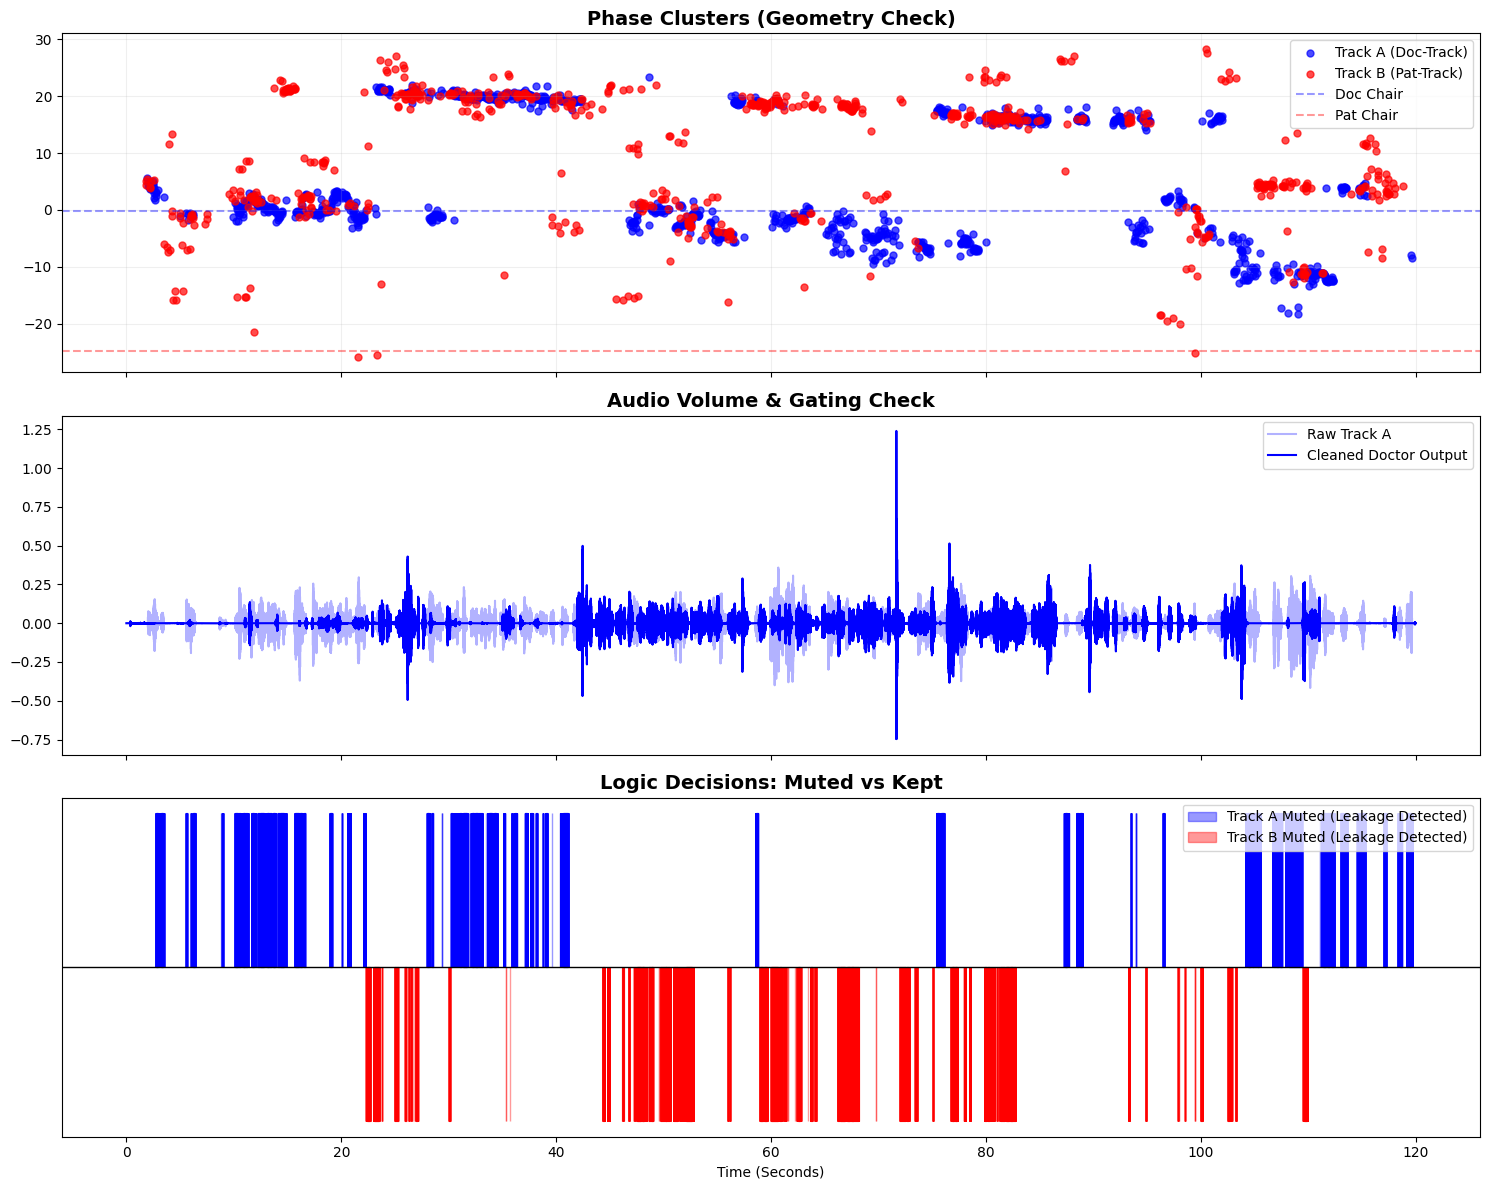

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_new_logic_clusters(start_sec, end_sec, radar_truth, clusters_t0, clusters_t1, track_a, track_b, f_doc, f_pat, sr=16000):
    """
    Visualizes how the new Zero-Latency logic handles clusters and routing.
    """
    s_idx, e_idx = int(start_sec * sr), int(end_sec * sr)
    time_axis = np.linspace(start_sec, end_sec, e_idx - s_idx)

    # Filter Clusters
    window_c0 = np.array([pt for pt in clusters_t0 if start_sec <= pt[0] <= end_sec])
    window_c1 = np.array([pt for pt in clusters_t1 if start_sec <= pt[0] <= end_sec])

    # Global Lane Anchors
    doc_pts = [r[1] for r in radar_truth if r[4] == "Doctor"]
    pat_pts = [r[1] for r in radar_truth if r[4] == "Patient"]
    doc_lane = np.median(doc_pts) if doc_pts else 10.0
    pat_lane = np.median(pat_pts) if pat_pts else -12.0

    fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

    # 1. TOP: SPATIAL MAPPING (Are clusters lining up?)
    if len(window_c0) > 0:
        axs[0].scatter(window_c0[:, 0], window_c0[:, 1], color='blue', s=25, alpha=0.7, label='Track A (Doc-Track)')
    if len(window_c1) > 0:
        axs[0].scatter(window_c1[:, 0], window_c1[:, 1], color='red', s=25, alpha=0.7, label='Track B (Pat-Track)')

    axs[0].axhline(doc_lane, color='blue', ls='--', alpha=0.4, label='Doc Chair')
    axs[0].axhline(pat_lane, color='red', ls='--', alpha=0.4, label='Pat Chair')
    axs[0].set_title("Phase Clusters (Geometry Check)", fontsize=14, fontweight='bold')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, alpha=0.2)

    # 2. MIDDLE: VOLUME ENVELOPES (Original vs Result)
    axs[1].plot(time_axis, track_a[s_idx:e_idx], color='blue', alpha=0.3, label='Raw Track A')
    axs[1].plot(time_axis, f_doc[s_idx:e_idx], color='blue', lw=1.5, label='Cleaned Doctor Output')
    axs[1].set_title("Audio Volume & Gating Check", fontsize=14, fontweight='bold')
    axs[1].legend(loc='upper right')

    # 3. BOTTOM: THE LOGIC TRACE (Why did it mute?)
    # We create a mask where the final output is zero but the raw track had audio
    doc_muted = (np.abs(track_a[s_idx:e_idx]) > 0.005) & (f_doc[s_idx:e_idx] == 0)
    pat_muted = (np.abs(track_b[s_idx:e_idx]) > 0.005) & (f_pat[s_idx:e_idx] == 0)

    axs[2].fill_between(time_axis, 0, 1, where=doc_muted, color='blue', alpha=0.4, label='Track A Muted (Leakage Detected)')
    axs[2].fill_between(time_axis, -1, 0, where=pat_muted, color='red', alpha=0.4, label='Track B Muted (Leakage Detected)')
    axs[2].axhline(0, color='black', lw=1)
    axs[2].set_title("Logic Decisions: Muted vs Kept", fontsize=14, fontweight='bold')
    axs[2].set_xlabel("Time (Seconds)")
    axs[2].set_yticks([])
    axs[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# RUN IT on a known swap or 'mhm' area
visualize_new_logic_clusters(0, 120, radar_master_key, clusters_t0, clusters_t1, track_a, track_b, hybrid_doc, hybrid_pat)


Finding clusters in AI Track 0...
Gathering raw spatial data...
Filtering out the noise...
Finding clusters in AI Track 1...
Gathering raw spatial data...
Filtering out the noise...


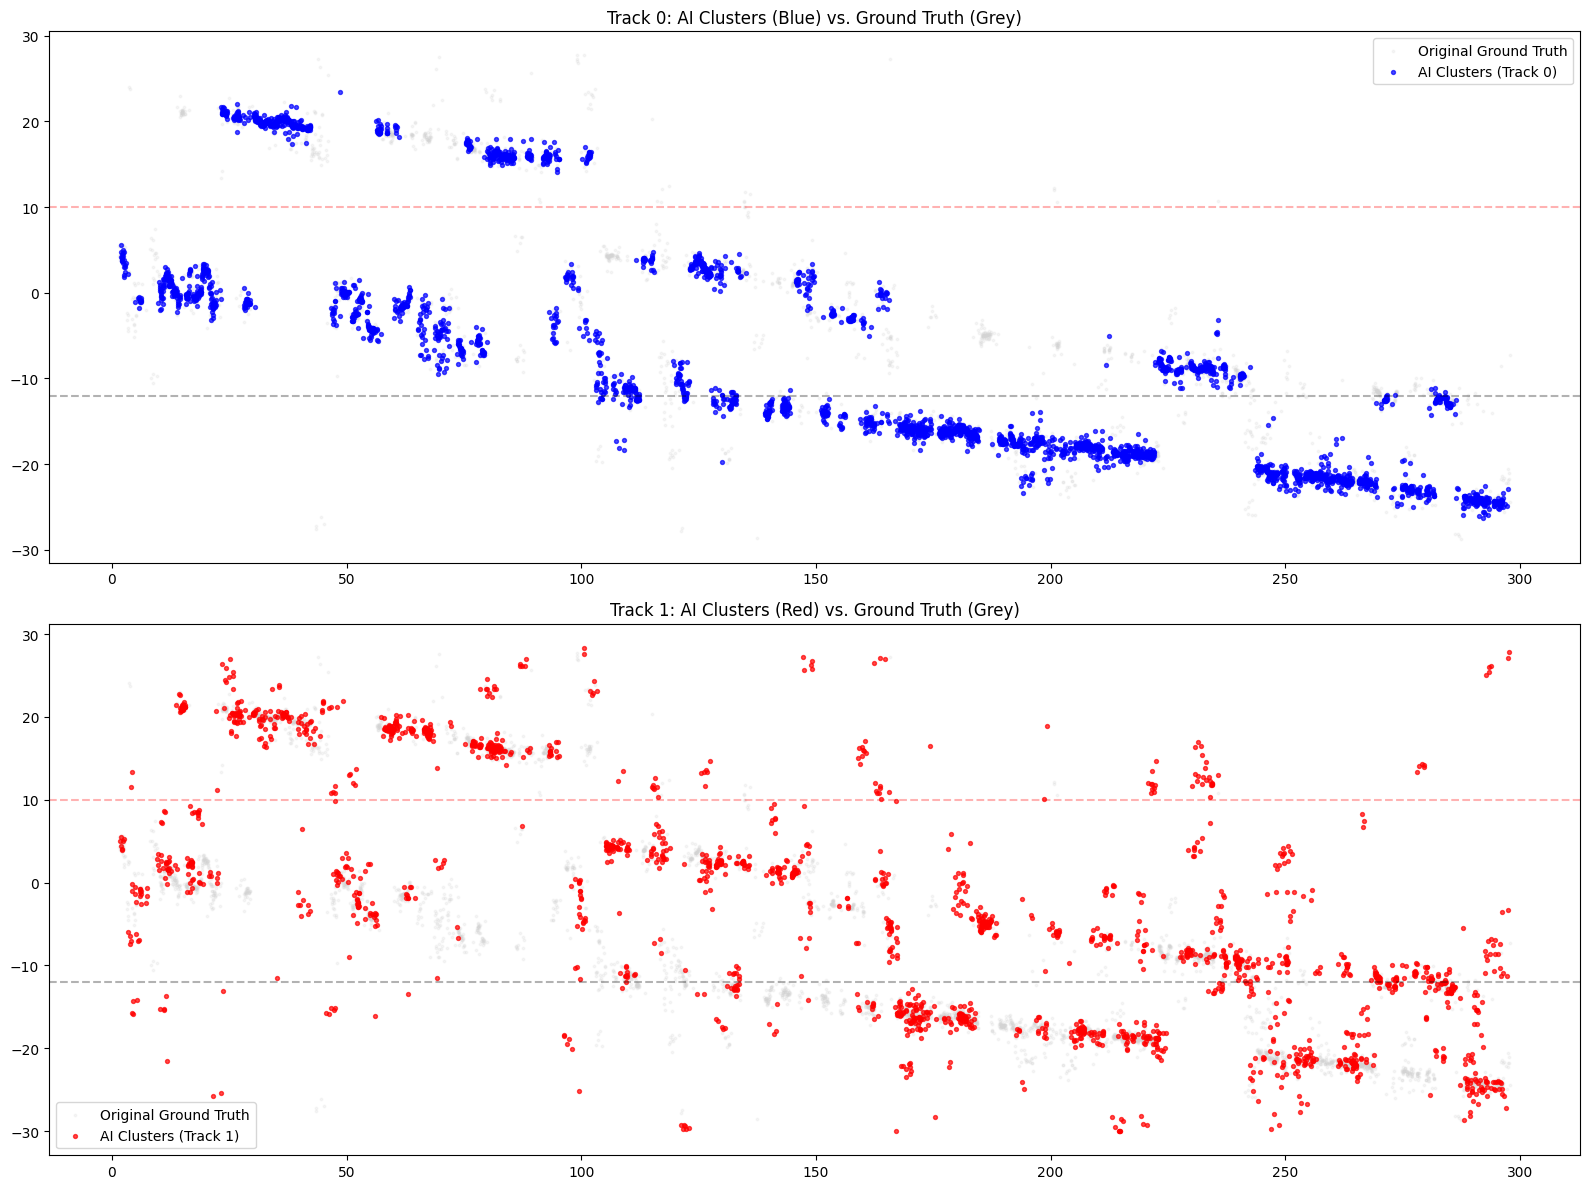

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_ai_clusters(original_dense, ai_track_0, ai_track_1, mic2_audio, sr=16000):
    # 1. RUN CLUSTER FINDING on the AI tracks
    def harvest_ai_clusters(ai_track, other_mic):
        # We use the 'Ultra-Sensitive' cluster finder you liked
        _, dense_pts = find_dense_clusters(ai_track, other_mic, sr=sr)
        return dense_pts

    print("Finding clusters in AI Track 0...")
    clusters_t0 = harvest_ai_clusters(ai_track_0, mic2_audio)

    print("Finding clusters in AI Track 1...")
    clusters_t1 = harvest_ai_clusters(ai_track_1, mic2_audio)

    # 2. PLOTTING
    plt.figure(figsize=(16, 12))

    # --- TOP: AI Track 0 ---
    plt.subplot(2, 1, 1)
    # Background (Ground Truth)
    plt.scatter(original_dense[:, 0], original_dense[:, 1], color='lightgrey', s=3, alpha=0.2, label="Original Ground Truth")
    # AI Clusters (What the AI actually kept)
    if len(clusters_t0) > 0:
        plt.scatter(clusters_t0[:, 0], clusters_t0[:, 1], color='blue', s=8, alpha=0.7, label="AI Clusters (Track 0)")
    plt.axhline(10, color='red', linestyle='--', alpha=0.3)
    plt.axhline(-12, color='black', linestyle='--', alpha=0.3)
    plt.title("Track 0: AI Clusters (Blue) vs. Ground Truth (Grey)")
    plt.legend()

    # --- BOTTOM: AI Track 1 ---
    plt.subplot(2, 1, 2)
    # Background (Ground Truth)
    plt.scatter(original_dense[:, 0], original_dense[:, 1], color='lightgrey', s=3, alpha=0.2, label="Original Ground Truth")
    # AI Clusters
    if len(clusters_t1) > 0:
        plt.scatter(clusters_t1[:, 0], clusters_t1[:, 1], color='red', s=8, alpha=0.7, label="AI Clusters (Track 1)")
    plt.axhline(10, color='red', linestyle='--', alpha=0.3)
    plt.axhline(-12, color='black', linestyle='--', alpha=0.3)
    plt.title("Track 1: AI Clusters (Red) vs. Ground Truth (Grey)")
    plt.legend()

    plt.tight_layout()
    plt.show()
track_a = m1_sep[0].squeeze()
track_b = m1_sep[1].squeeze()
# --- EXECUTE ---
# Use 'raw_dense' (your perfect ground truth) and the 'ai_tr0'/'ai_tr1' from MossFormer
overlay_ai_clusters(raw_dense, track_a, track_b, patient_audio)

In [ ]:
import matplotlib.pyplot as plt

def visualize_final_stitched_clusters(raw_dense, final_doc_audio, final_pat_audio, ref_mic_audio, sr=16000):
    print("Harvesting spatial clusters for the FINAL stitched files... (this might take a second)")

    # 1. Run your cluster finder on the newly stitched tracks
    # We compare the final separated tracks against the original reference mic
    _, doc_clusters = find_dense_clusters(final_doc_audio, ref_mic_audio, sr=sr)
    _, pat_clusters = find_dense_clusters(final_pat_audio, ref_mic_audio, sr=sr)

    # 2. PLOTTING
    plt.figure(figsize=(16, 12))

    # --- TOP: Final Doctor Track ---
    plt.subplot(2, 1, 1)
    # Background Ghost Map
    plt.scatter(raw_dense[:, 0], raw_dense[:, 1], color='lightgrey', s=3, alpha=0.2, label="Original Ground Truth")

    # Stitched Doctor Clusters
    if len(doc_clusters) > 0:
        plt.scatter(doc_clusters[:, 0], doc_clusters[:, 1], color='blue', s=8, alpha=0.7, label="Final Doctor Track")

    plt.axhline(10, color='blue', linestyle='--', alpha=0.3, label="Expected Doctor Lane")
    plt.axhline(-12, color='red', linestyle='--', alpha=0.3, label="Expected Patient Lane")
    plt.title("FINAL STITCHED: Doctor Track (Should ONLY hover near top line)", fontsize=14, fontweight='bold')
    plt.ylabel("Phase Shift (tau)")
    plt.legend()

    # --- BOTTOM: Final Patient Track ---
    plt.subplot(2, 1, 2)
    # Background Ghost Map
    plt.scatter(raw_dense[:, 0], raw_dense[:, 1], color='lightgrey', s=3, alpha=0.2, label="Original Ground Truth")

    # Stitched Patient Clusters
    if len(pat_clusters) > 0:
        plt.scatter(pat_clusters[:, 0], pat_clusters[:, 1], color='red', s=8, alpha=0.7, label="Final Patient Track")

    plt.axhline(10, color='blue', linestyle='--', alpha=0.3)
    plt.axhline(-12, color='red', linestyle='--', alpha=0.3)
    plt.title("FINAL STITCHED: Patient Track (Should ONLY hover near bottom line)", fontsize=14, fontweight='bold')
    plt.ylabel("Phase Shift (tau)")
    plt.xlabel("Time (seconds)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- EXECUTE IT ---
# finaldoc and finalpat are the outputs from our stitching function
# patient_audio is your raw reference mic from earlier
visualize_final_stitched_clusters(raw_dense, finaldoc, finalpat, patient_audio)